# OMNY Analysis

This notebook is created with the goal of analysing transit data. By passing in a CSV dataset exported by NYC MTA's OMNY fare system, information such as time of day, trips per week, most-visited stations, and more can be determined

## Getting the CSV Data

- Go to https://omny.info/ and log in
- Go to Trips https://omny.info/account/trips and update the filter to show the past 12 months (the max time range possible)
- Scroll to the bottom of the page, click "Download trip history" and pick CSV and then download
- (Optional) manually merge this data with previously-downloaded data using Excel or Sublime
  - Alternatively, Pandas can read multiple CSV files and pick unique rows
- Place the CSV files in the same directory as the Jupyter notebook, aka this Git repo

In [1]:
# Load libraries
import pandas as pd # pd is the standard alias https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html
import seaborn as sns # sns is the convention https://seaborn.pydata.org/tutorial/introduction.html

## Loading the CSV Data

- Read the CSV files into Pandas as separate dataframes
- Merge them together using concat
- Get the unique rows based on Reference ID, in case the OMNY exports had overlapping data
- Resources
  - https://medium.com/@harryfry/combining-multiple-csv-files-into-one-with-pandas-97f631d67960
  - https://www.geeksforgeeks.org/how-to-merge-multiple-csv-files-into-a-single-pandas-dataframe/#
  - Use lower_case_with_underscore https://peps.python.org/pep-0008/#function-and-variable-names
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
  - https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [2]:
# Edit this to update the CSV data files to be considered
files_to_read = ['trip-history.csv','trip-history2.csv']

# Read from CSV and concatenate in one line
# Index is not important and can be ignored 
df = pd.concat(map(pd.read_csv, files_to_read), ignore_index=True)

print("Raw CSV Data has row count of", len(df))

# Reference is a unique ID per fare payment, and can be used to get unique rows
df.drop_duplicates(subset=['Reference'],inplace=True,ignore_index=True)

print("Unique CSV Data has row count of", len(df))


Raw CSV Data has row count of 158
Unique CSV Data has row count of 149


## Massage and Format the DataFrame

- The DataFrame, upon initial read from CSV, is mostly Objects
```
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Reference          int64 
 1   Transit Account #  int64 
 2   Trip Time          object
 3   Mode               object
 4   Location           object
 5   Product Type       object
 6   Fare Amount ($)    object
dtypes: int64(2), object(5)
```
- However, many of the fields are categorical, meaning there is a finite set of possibile values. This allows Pandas to process it more efficiently
- Some fields are also date-based or numeric, and can be interpreted as such
- The column names can also be hard to reference, given their whitespace and special characters. They can be renamed
- Resources
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html#pandas.DataFrame.info
  - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
  - https://lifewithdata.com/2022/02/28/how-to-convert-a-string-column-to-float-in-pandas/
  - https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas
  - https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [7]:
# Rename columns to be easier to reference
df = df.rename(columns={'Reference':'trip_id',
                   'Transit Account #':'rider_id',
                   'Trip Time':'start_time',
                   'Mode':'transit_mode',
                   'Location':'start_location',
                   'Product Type':'product_type',
                   'Fare Amount ($)':'fare_cost'})

# Convert categorical fields from object to category
df = df.astype({'rider_id': 'category','transit_mode': 'category','start_location': 'category','product_type': 'category'})

# Convert object column with "$2.75" to a float, stripping out the $ to prepare it for interpretation
df['fare_cost'] = df['fare_cost'].astype(str).str.replace('$', '').astype(float)


# Convert Trip Time object column with value such as 2022-07-19 20:50:29 into a datetime type
df['start_time'] = pd.to_datetime(df['start_time'])



df.info(show_counts=False)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   trip_id         int64         
 1   rider_id        category      
 2   start_time      datetime64[ns]
 3   transit_mode    category      
 4   start_location  category      
 5   product_type    category      
 6   fare_cost       float64       
dtypes: category(4), datetime64[ns](1), float64(1), int64(1)
memory usage: 6.0 KB


,trip_id,rider_id,start_time,transit_mode,start_location,product_type,fare_cost
0,69380562,573091239506,2022-07-19 20:50:29,Subway,Delancey St / Essex St,Stored Value,2.75
1,69334012,573091239506,2022-07-19 17:29:15,Subway,Sutter Av,Stored Value,2.75
2,69155345,573091239506,2022-07-18 11:15:54,Subway,Astoria - Ditmars Blvd,Stored Value,2.75
3,69152883,573091239506,2022-07-18 10:18:18,Subway,Sutter Av,Stored Value,2.75
4,68906830,573091239506,2022-07-15 19:36:25,Subway,Jackson Hts-Roosevelt Av / 74 St,Stored Value,2.75
...,...,...,...,...,...,...,...
144,59127703,573091239506,2022-05-08 17:16:27,Subway,7 Av,Stored Value,2.75
145,52300806,573091239506,2022-03-26 14:45:16,Subway,7 Av,Stored Value,2.75
146,52292551,450293034846,2022-03-26 14:45:15,Subway,7 Av,Stored Value,2.75
147,50476491,450293034846,2022-03-19 14:18:08,Subway,7 Av,Stored Value,2.75


## Location-based analysis

- This looks at how the different stations and stops in the MTA system are accessed. 
  - How many stations have only been visited once?
  - What are the most popular stations?
  - Do the different rider_ids frequent different stations?
- Resources
  - Use a semicolon after plotting to avoid text such as `<Axes: xlabel='count', ylabel='start_location'>` from showing before the plot https://stackoverflow.com/questions/57165540/hide-text-before-seaborn-barplot
  - Use `sns.set(rc={'figure.figsize':(5,20)})` (x,y) to change the plot size https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
  - Add `.set(xlabel='x-axis label', ylabel='y-axis label')` to add specific labels https://www.statology.org/seaborn-axis-labels/
  - Add a title using the same method, `.set(title='title')` https://www.statology.org/seaborn-title/
  - Order by the number of occurrences https://stackoverflow.com/questions/46623583/order-categories-by-count-in-a-seaborn-countplot
  - Mix this with `.iloc[:10]` before `.index` to limit to the top 10 https://stackoverflow.com/questions/32891211/limit-the-number-of-groups-shown-in-seaborn-countplot

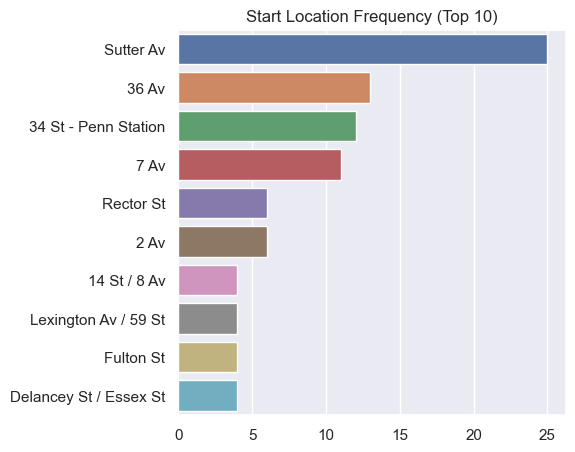

In [4]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(y=df["start_location"], order=df["start_location"].value_counts().iloc[:10].index).set(ylabel=None, xlabel=None, title='Start Location Frequency (Top 10)');


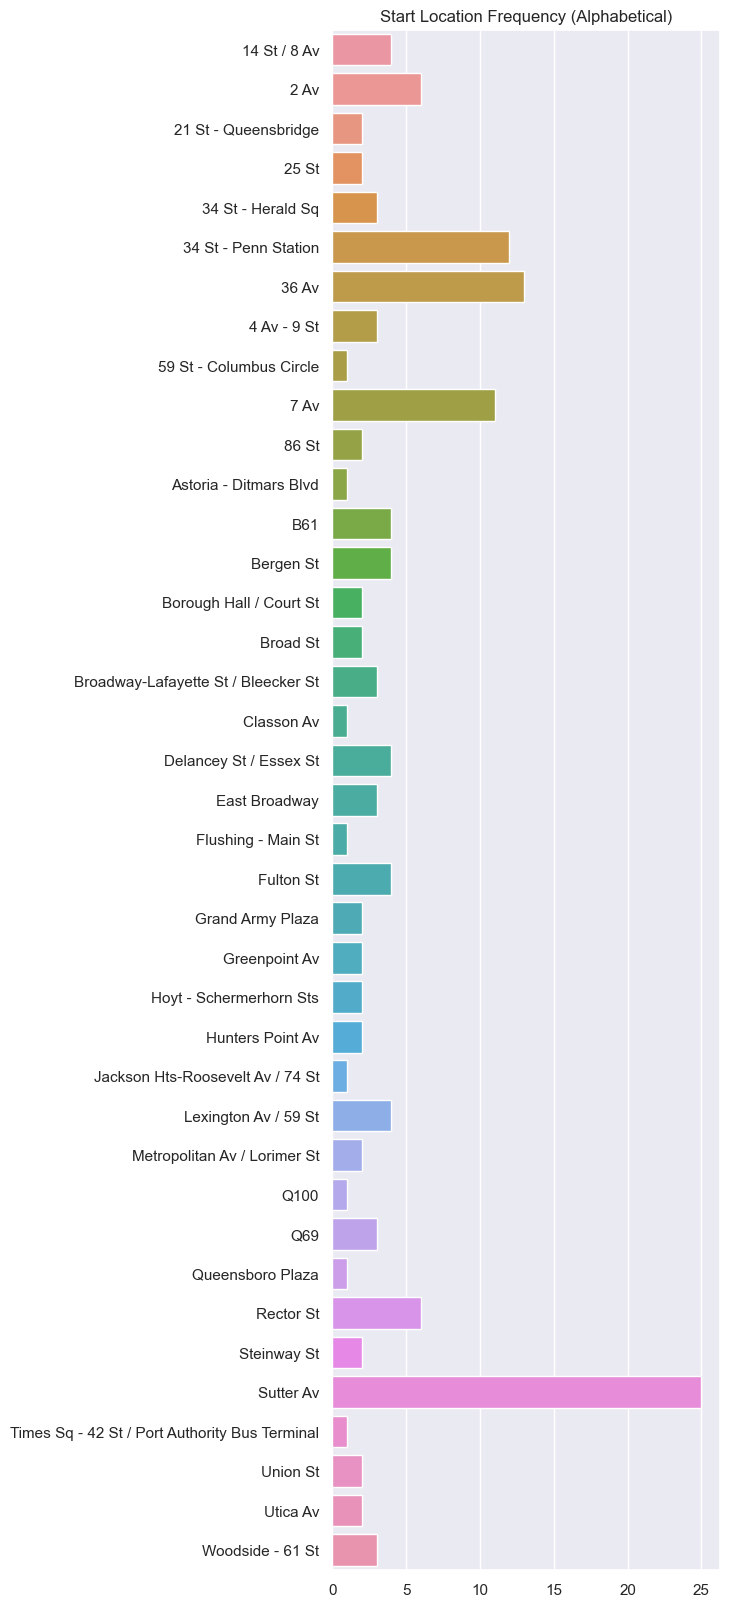

In [5]:
sns.set(rc={'figure.figsize':(5,20)})
sns.countplot(y=df["start_location"]).set(ylabel=None, xlabel=None, title='Start Location Frequency (Alphabetical)');


## Time-based analysis

- This looks at how transit happens over different time periods
  - What times of day are most common?
  - What weeks, months, and quarters of the year had the most trips?
  - How many weeks went over the 12 ride fare cap, and how many came close?
- Resources
  - TBD

## Cost-based analysis 

- This looks at the financial side of things
  - What starting day of the week best utilizes the fare cap?
  - What is the average/max monthly spend rate?
- Resources
  - TBD